# Thermal Convection

This example solves 2D dimensionless isoviscous thermal convection with a Rayleigh number of $10^4$, see Blankenbach *et al.* 1989 for details.

**References**

B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract

In [1]:
from underworld import UWGeodynamics as GEO
from underworld import visualisation as vis

loaded rc file /home/romain/Projects/Project_Surface_processes/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.u

In [3]:
boxHeight = 1000. * u.kilometer
boxLength = 2000. * u.kilometer

tempMin = 273.15 * u.degK
tempMax = 1273.15 * u.degK

refViscosity = 1e23 * u.pascal * u.second

KL = boxHeight
KT = (tempMax - tempMin)
Kt = 1.0 * u.megayear
KM = refViscosity * KL * Kt

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[temperature]"]= KT
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"] = KM

In [4]:
Model = GEO.Model(elementRes=(64, 64), 
                  minCoord=(0. * u.kilometer, 0. * u.kilometer), 
                  maxCoord=(2000. * u.kilometer, 1000. * u .kilometer),
                  gravity=(0., -10. * u.meter / u.second**2))

In [5]:
Model.outputDir = "1_02_ConvectionExample"

## Define Material property

In [6]:
Model.density = GEO.LinearDensity(4000. * u.kilogram / u.metre**3, thermalExpansivity=2.5e-5 / u.degK)
Model.diffusivity = 1e-6 * u.metre**2 / u.second
Model.viscosity = 1e23 * u.pascal * u.second

The Raylegh number is defined as 

$$ Ra_0 = \frac{\alpha g \Delta T h^3}{\kappa \mu_0} $$

$\alpha$ is thermal expansion coefficient,
$\kappa$ is diffusivity,
$g$ is gravity,
$dT$ is the difference in temperature between top and bottom,
$h$ is the Model height,
$mu0$ is the kinematic viscosity.

In [7]:
alpha = Model.thermalExpansivity
kappa = Model.diffusivity
g = abs(Model.gravity[-1])
dT = KT
h = Model.height
mu0 = (1e23 * u.pascal * u.second) / (4000 * u.kilogram / u.metre**3)

Ra0 = (alpha * g * dT * h**3) / (kappa * mu0)

print("Rayleigh Number:", Ra0.to_base_units())

Rayleigh Number: 10000.000000000004 dimensionless


## Define velocity boundary conditions

In [8]:
VelocityBCs = Model.set_velocityBCs(left=[0., None], right=[0.,None], top=[None,0.], bottom=[None,0.])

## Define thermal boundary conditions

In [9]:
BoundaryBCs = Model.set_temperatureBCs(top=tempMin, bottom=tempMax)

## Define Initial Temperature perturbation

In [10]:
import math

boxLength = GEO.nd(boxLength)
boxHeight = GEO.nd(boxHeight)
tempMin = GEO.nd(tempMin)
tempMax = GEO.nd(tempMax)

Model.temperature.data[:] = 0.
pertStrength = GEO.nd(200. * u.kilometer)
deltaTemp = tempMax - tempMin

for index, coord in enumerate(Model.mesh.data):
    pertCoeff = math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    Model.temperature.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    Model.temperature.data[index] = max(tempMin, min(tempMax, Model.temperature.data[index]))


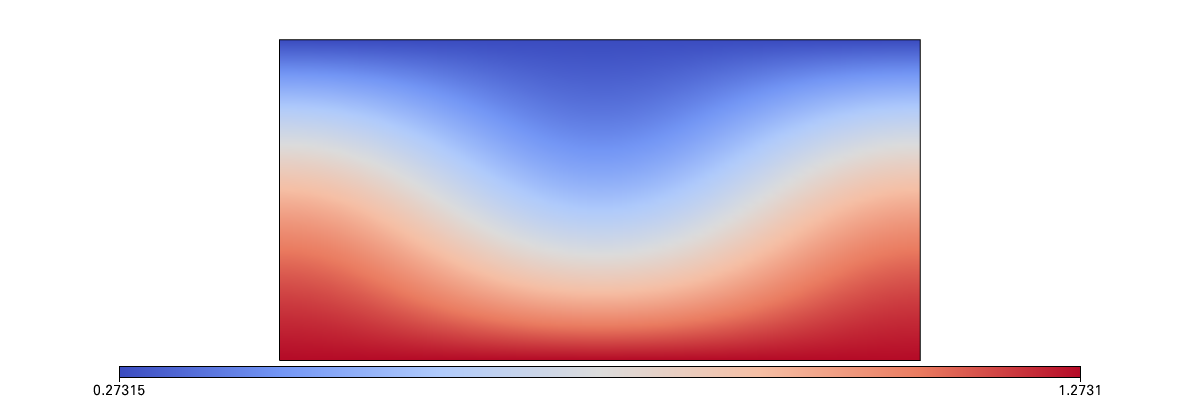

In [11]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.temperature, colours="coolwarm")
Fig.save("Figure_1.png")
Fig.show()

In [12]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

In [14]:
Model.init_model(pressure="lithostatic")

/home/romain/Projects/Project_Surface_processes/UWGeodynamics/UWGeodynamics/_model.py:1524: UserWarning: You have not passed anything to the temperature argument. The temperature field will not be initialised
  warnings.warn("You have not passed anything to the temperature argument. The temperature field will not be initialised")


In [15]:
Model.run_for(20000.0 * u.years)

Running with UWGeodynamics version 2.10.5
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 20000.0 year dt: 20000.0 year (2021-02-19 10:38:23)


1


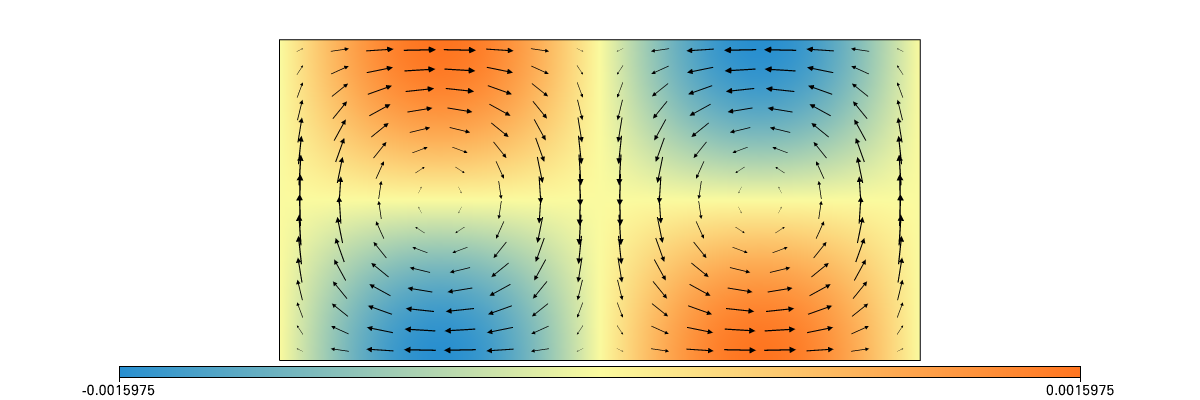

In [16]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.velocityField[0])
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.save("Figure_2.png")
Fig.show()


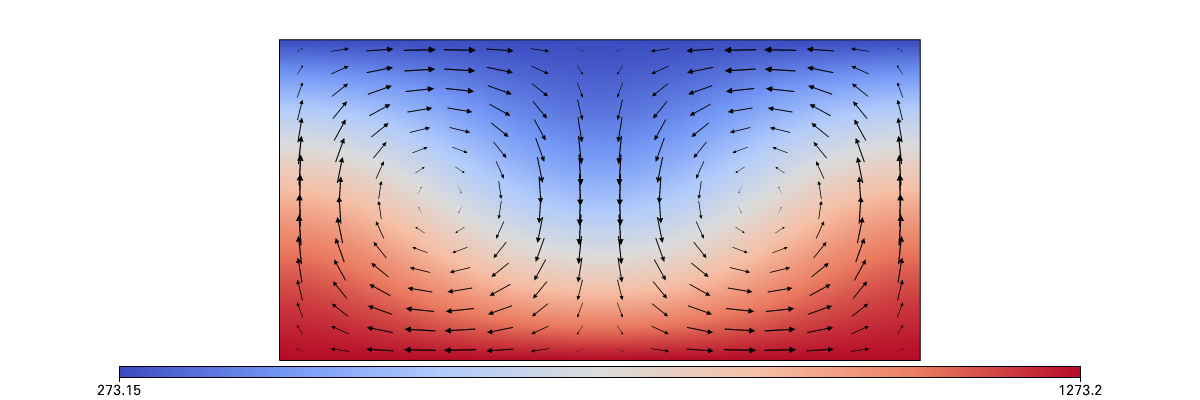

In [17]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.temperature, u.degK), colours="coolwarm")
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.save("Figure_3.png")
Fig.show()